<a href="https://colab.research.google.com/github/Andrade020/Teste-MeetupR/blob/master/Balanceador_de_investimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
for i in range(50000): time.sleep(10)

In [ ]:
!pip install finpie
!pip install rpy2

In [7]:
import finpie
import finpie.price_data
from finpie import NewsData
from finpie import price_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import math
import rpy2
%load_ext rpy2.ipython

Referências:

https://faculty.fuqua.duke.edu/~charvey/Teaching/BA453_2006/Idzorek_onBL.pdf(Mostra como obter a matriz Ômega com base nos seus *views*)
The Black-Litterman Model In Detail- Jay Walters
(Mostra como simplificar analiticamente a expansão de Idzorek)

TODOS OS VIDEOS do Phil Davies(Ex: https://www.youtube.com/watch?v=lIhGv1oYS8U)- explica didaticamente a intuição e implementação em excel dos principais modelos de mercado

https://repositorio.iscte-iul.pt/bitstream/10071/15315/1/yihao_chen_diss_mestrado.pdf (apesar de a tese em si ser meio inútil,o artigo funciona como uma espécie hub para outros artigos, por apresentar uma introdução estilo *survey*)

https://medium.datadriveninvestor.com/use-python-to-value-a-stock-automatically-3b520422ab6 (foi de onde raspei boa parte do código da análise fundamentalsita para o cálculo de valor intrínsico)





StackOverflow foi usado intensamente e sem dó para resolver pequenos erros e dúvidas. As vezes, Wikipedia para dúvidas e curiosidades matemáticas. Também temos as documentações das bibliotecas. As principais são: Finpie(https://pypi.org/project/finpie/#f131) e hux(https://hughjonesd.github.io/huxtable/)




Referências Complementares:

EFFICIENT ASSET MANAGEMENT- Michaud(+ webinar "descostructing BL model")
(apresenta críticas fundamentais ao modelo BL- tais como o uso de matriz de covariância para estimar a média e a negligência de tau conduzem a resultados falaciosos)

https://faculty.fuqua.duke.edu/~charvey/Teaching/IntesaBci_2001/GS_The_intuition_behind.pdf (explica como os retornos implicados de mercado se relacionam com os retornos do CAPM)

https://www.investopedia.com/terms/i/informationratio.asp(pra calcular o valor do tau sem excerder IR>2)

https://docs.tibco.com/pub/sfire-dsc/6.5.0/doc/html/TIB_sfire-dsc_user-guide/GUID-C4D05ED0-3392-4407-B62A-7D29B26DC566.html 
(explicação simples e concisa da dedução da fórmula da regressão logística)

Optimal Currency Hedging: Horizon Matters- Nelson Arruda
(prova meio confusa de que a estimativa de minVar só funciona no curto prazo... ignorável)

THE INFLUENCE OF FUNDAMENTAL FACTORS ON STOCK RETURN- Sonnia Cindy Tamuunu(roda uma regressão similar a minha para descobrir o impacto das variáveis fundamentalistas nos retornos)

In [8]:
def calculate_intrinsic_value(acao): 
    time.sleep(22) 
    cshflwstate=finpie.Fundamentals(acao, source = 'yahoo', freq = 'A').cashflow_statement()
    time.sleep(22)
    blsheet= finpie.Fundamentals(acao, source = 'yahoo', freq = 'A').balance_sheet()
    time.sleep(22)
    keymetr= finpie.Fundamentals(acao, source = 'yahoo', freq = 'A').key_metrics()
    time.sleep(22)
    incomest=finpie.Fundamentals(acao, source = 'yahoo', freq = 'A').income_statement()
    cash_flow= cshflwstate.iloc[0]['free_cash_flow']
    total_debt= blsheet.iloc[0]['total_debt'] #ver total debit do key metrics
    Beta= keymetr.iloc[0]['beta_(5y_monthly)']
    cash_and_ST_investments= keymetr.iloc[0]['total_cash_(mrq)']*4
    shares_outstanding= keymetr.iloc[0]['shares_outstanding']
    EPS_growth_5Y= np.minimum(((incomest.iloc[0]['basic_eps']-incomest.iloc[-1]['basic_eps'])*1.25), 6.7)
    if(math.isnan(EPS_growth_5Y)==True): EPS_growth_5Y=6.7
    EPS_growth_6Y_to_10Y= np.minimum(EPS_growth_5Y, 5)
    EPS_growth_11Y_to_20Y=np.minimum(EPS_growth_6Y_to_10Y, 4)
    discount_rate = 7          ##########agora vou calcular a taxa de desconto baseada no Beta(compensacao pelo risco)
    if(Beta<0.80):
        discount_rate = 5
    elif(Beta>=0.80 and Beta<1):
        discount_rate = 6
    elif(Beta>=1 and Beta<1.1):
        discount_rate = 6.5
    elif(Beta>=1.1 and Beta<1.2):
        discount_rate = 7
    elif(Beta>=1.2 and Beta<1.3):
        discount_rate =7.5
    elif(Beta>=1.3 and Beta<1.4):
        discount_rate = 8
    elif(Beta>=1.4 and Beta<1.6):
        discount_rate = 8.5
    elif(Beta>=1.61):
        discount_rate = 9    
    
    # Convert all percentages to decmials
    EPS_growth_5Y_d = EPS_growth_5Y/100
    EPS_growth_6Y_to_10Y_d = EPS_growth_6Y_to_10Y/100
    EPS_growth_11Y_to_20Y_d = EPS_growth_11Y_to_20Y/100
    discount_rate_d = discount_rate/100
  #  print("Fluxos de caixa descontados\n")
    
    # Lists of projected cash flows from year 1 to year 20
    cash_flow_list = []
    cash_flow_discounted_list = []
    year_list = []
    
    
    # Years 1 to 5
    for year in range(1, 6):
        year_list.append(year)
        cash_flow*=(1 + EPS_growth_5Y_d)        
        cash_flow_list.append(cash_flow)
        cash_flow_discounted = cash_flow/((1 + discount_rate_d)**year)
        cash_flow_discounted_list.append(cash_flow_discounted)
       # print("Ano " + str(year) + ": $" + str(cash_flow_discounted)) ## Print out the projected discounted cash flows
    
    # Years 6 to 10
    for year in range(6, 11):
        year_list.append(year)
        cash_flow*=(1 + EPS_growth_6Y_to_10Y_d)
        cash_flow_list.append(cash_flow)
        cash_flow_discounted = cash_flow/((1 + discount_rate_d)**year)
        cash_flow_discounted_list.append(cash_flow_discounted)
      #  print("Ano " + str(year) + ": $" + str(cash_flow_discounted)) ## Print out the projected discounted cash flows
    
    # Years 11 to 20
    for year in range(11, 21):
        year_list.append(year)
        cash_flow*=(1 + EPS_growth_11Y_to_20Y_d)
        cash_flow_list.append(cash_flow)
        cash_flow_discounted = cash_flow/((1 + discount_rate_d)**year)
        cash_flow_discounted_list.append(cash_flow_discounted)
     #   print("ANO " + str(year) + ": $" + str(cash_flow_discounted)) ## Print out the projected discounted cash flows
    
    intrinsic_value = (sum(cash_flow_discounted_list) - total_debt + cash_and_ST_investments)/shares_outstanding
   # df = pd.DataFrame.from_dict({'Ano': year_list, 'Fluxo de caixa': cash_flow_list, 'Fluxo de caixa descontado': cash_flow_discounted_list})
   # df.index = df.Ano
   # df.plot(kind='bar', title = 'Projecao de fluxos de caixa de ' + acao)
    plt.show()

    return intrinsic_value


In [9]:
def confianca(tickers): #recebe acoes e retorna vetor com as expectativas da regressao fundamentalista
  valores=[]
  for acao in tickers: 
    time.sleep(2)
    keymetrics= finpie.Fundamentals(acao, source = 'yahoo', freq = 'A').key_metrics()
    remaining_download_tries = 50
    blsheet= None
    while blsheet is None:
        time.sleep(22)
        blsheet= finpie.Fundamentals(acao, source = 'yahoo', freq = 'A').balance_sheet()
    ROA= np.nan_to_num(keymetrics.iloc[0]['return_on_assets_(ttm)'])
    PBV= np.nan_to_num(keymetrics.iloc[0]['book_value_per_share_(mrq)'])
    CR= np.nan_to_num(keymetrics.iloc[0]['current_ratio_(mrq)'])
    if(CR==0): CR= np.nan_to_num((blsheet.iloc[0]['total_assets'])/blsheet.iloc[0]['total_liabilities_net_minority_interest'] )
    DER= blsheet.iloc[0]['total_liabilities_net_minority_interest']/ (blsheet.iloc[0]['total_assets']-blsheet.iloc[0]['total_liabilities_net_minority_interest'])
    Yexp= (-0.003+ 0.002*ROA+ 0.001*CR- 0.001*DER+ 0.001*PBV)*20
    valores.append(Yexp)
  return valores   

In [ ]:
%%R
install.packages("quantmod")
install.packages("PerformanceAnalytics")
install.packages("PortfolioAnalytics")
install.packages("ROI.plugin.quadprog")
install.packages("ROI.plugin.glpk")
install.packages("stringr")##
install.packages("stringi")
install.packages("matlib")
install.packages("tidyverse")
install.packages("data.table")
install.packages("dplyr")
install.packages("formattable")
install.packages("tidyr")
install.packages('huxtable')

In [ ]:
%%R
library(quantmod)
library(PerformanceAnalytics)
library(PortfolioAnalytics)
library(ROI.plugin.quadprog)
library(huxtable)
#library(ROI.plugin.glpk)
library(stringr)##
library(stringi)
library(matlib)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(data.table)
library(dplyr)
library(formattable)
library(tidyr)

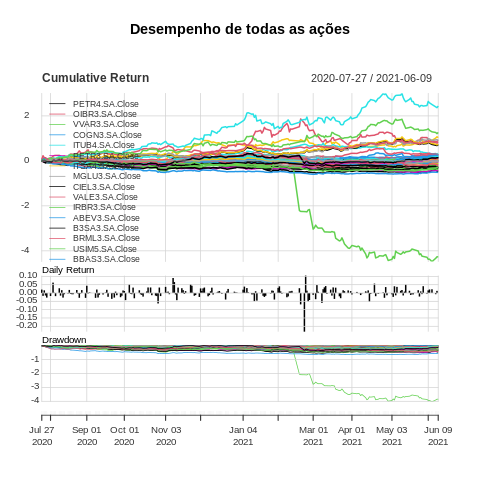

In [5]:
%%R
########################################################################
# em quantos ativos você teria paciência para investir? 
q=10
#######################################################################
#quanto esta a taxa selic? 
tx= 0.0001785
###############################################################
tickers<- c("PETR4.SA","OIBR3.SA","VVAR3.SA","COGN3.SA","ITUB4.SA","PETR3.SA","ITSA4.SA","MGLU3.SA","CIEL3.SA","VALE3.SA","IRBR3.SA","ABEV3.SA","B3SA3.SA","BRML3.SA","USIM5.SA","BBAS3.SA","CSNA3.SA","LAME4.SA","GGBR4.SA","EMBR3.SA","GOAU4.SA","JBSS3.SA","GFSA3.SA","MRFG3.SA","BRDT3.SA","LWSA3.SA","UGPA3.SA","POMO4.SA","HAPV3.SA","EQTL3.SA","RAIL3.SA","CCRO3.SA","MULT3.SA","CMIG4.SA","PCAR3.SA","BRFS3.SA","BEEF3.SA","MEAL3.SA","CVCB3.SA","GOLL4.SA","SUZB3.SA","LREN3.SA","AZUL4.SA","ELET3.SA","DMMO3.SA","JHSF3.SA")
marketPrices<- NULL
marketReturns<-NULL
for (ticker in tickers){
  marketPrices<- cbind(marketPrices, na.omit(getSymbols.yahoo(ticker, from="2020-07-24", periodicity = 'daily', auto.assign=F)[,4]))
  #recomendacao: 2020-07-24
}
benchmarkPrices<- na.omit(getSymbols.yahoo('^BVSP', from="2020-07-24", periodicity = 'daily', auto.assign=F)[,4])
benchmarkReturns<- na.omit(ROC(benchmarkPrices)) #ROC significa Rate of Change, geometrico
selic=list()

marketReturns<-na.omit(ROC(marketPrices)) # df com retornos de todas as acoes
n=(nrow(marketReturns)) ###calculo o numero de dias
for (i in 1:n ){                             ##serie com os dados da taxa livre de risco
  selic[i]<- tx
}
selic[3]<- -tx
marketReturns$tesouro <- selic          ## incorpora taxa livre de risco

rets_df<- cbind(marketReturns, benchmarkReturns)
charts.PerformanceSummary(rets_df, main="Desempenho de todas as ações") # grafico mostrando os retornos de todas as acoes
#chart.CumReturns(rets_df, main="Desempenho de todas as ações")

In [10]:
%%R --o preco_hj --o lista_ativos --o listasj
portf<- portfolio.spec(colnames(marketReturns))# especifica os nomes das colunas 
portf<- add.constraint(portf, type="weight_sum", min_sum=0.99, maxsum=1.01) # o quanto os pesos devem somar
portf<- add.constraint(portf, type="box", min=0.00, max=(1/q))# o quanto em % podemos investir em cada
portf<- add.objective(portf,  type="return", name="mean") # maximiza retorno, e vai usar mean pra grafico
portf<- add.objective(portf,  type="risk", name="StdDev") # agora minimiza o risco
# agora precisamos usar um solver pra resolver o problema de otimizacao com as res
optPort<- optimize.portfolio(marketReturns, portf, optimize_method = "ROI", trace=TRUE)
#tail(sort(unlist(optPort$weights, use.names = FALSE)), q)  # isso mostra as melhores acoes escolhiudas e seus pesos
optAtv=tail(sort(unlist(optPort$weights)), q) ### salvando as variaveis
lista_ativos= rownames(data.frame(optAtv))
listasj=lista_ativos

preco_hj<-NULL
for (ativo in listasj){
    preco_hj= cbind(preco_hj, marketPrices[,ativo][length(marketPrices[,ativo])] )
}
preco_hj


print("lista de ativos escolhidos:")
print( lista_ativos)

[1] "lista de ativos escolhidos:"
 [1] "BRFS3.SA.Close" "AZUL4.SA.Close" "CSNA3.SA.Close" "GGBR4.SA.Close"
 [5] "EMBR3.SA.Close" "SUZB3.SA.Close" "LWSA3.SA.Close" "VALE3.SA.Close"
 [9] "GOAU4.SA.Close" "USIM5.SA.Close"


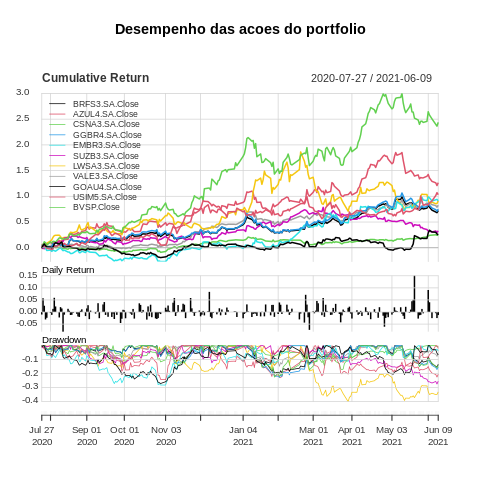

In [11]:
%%R --o miCAPM --o rf --o S
portfolioPrices<- NULL
for (ativo in c(lista_ativos)){
  y=(deparse(ativo))
  x=str_replace_all(y,"\u0022", "")
  portfolioPrices<- cbind(portfolioPrices, marketPrices[,x])
}
###############################################################
portfolioReturns<-na.omit(ROC(portfolioPrices))
portf_df<- cbind(portfolioReturns, benchmarkReturns)
charts.PerformanceSummary(portf_df, main="Desempenho das acoes do portfolio")
############################
portf1<- portfolio.spec(colnames(portfolioReturns))# especifica os nomes das colunas 
portf1<- add.constraint(portf1, type="weight_sum", min_sum=0.99, maxsum=1.01) # o quanto os pesos devem somar
portf1<- add.constraint(portf1, type="box", min=0.00, max=0.5)# o quanto em % podemos investir em cada
portf1<- add.objective(portf1,  type="return", name="mean") # maximiza retorno, e vai usar mean pra grafico
portf1<- add.objective(portf1,  type="risk", name="StdDev") # agora minimiza o risco
# agora precisamos usar um solver pra resolver o problema de otimizacao com as res
optPort1<- optimize.portfolio(portfolioReturns, portf1, optimize_method = "ROI", trace=TRUE)

###########################agora tentarei calcular o peso otimo de acordo com diferentes teorias
    ##para tanto, comecarei por estipular os valores das variaveis usadas nos modelos
     ##referencias em https://www.youtube.com/watch?v=AwEvXrAxbNU&list=PLlIJjE1EmA8Y6egvj9yRgJbbxf_iEmPYv&index=16
S= cov(portfolioReturns) # matriz de variância/ covariância
CAPM.beta(portfolioReturns[,x], benchmarkReturns, tx)
Erm=sum(benchmarkReturns)/length(benchmarkReturns)
rf<-NULL
for (i in 1:length(lista_ativos)){ rf= cbind(rf, tx)} 
sigma2_m= var(benchmarkReturns)
betas<-NULL
for (ativo in c(lista_ativos)){
  y=(deparse(ativo))
  x=str_replace_all(y,"\u0022", "")
  betas<- cbind(betas, CAPM.beta(portfolioReturns[,x], benchmarkReturns, tx))
}
colnames(betas)<-lista_ativos
miCAPM= rf+ (Erm-rf)*betas
miHIST<-NULL
for (ativo in c(lista_ativos)){
  y=(deparse(ativo))
  x=str_replace_all(y,"\u0022", "")
  miHIST<- cbind(miHIST, sum(portfolioReturns[,x])/length(portfolioReturns[,x]) )
}
zCAPM= inv(S)%*%t((miCAPM-rf))
wCAPM= zCAPM/(sum(zCAPM))
wMINVAR=extractWeights(optPort1)

rownames(wCAPM)<-lista_ativos
################essa eh a recomendacao de pesos do CAPM
zHIST= inv(S)%*%t((miHIST-rf))
wHIST= zHIST/(sum(zHIST))
rownames(wHIST)<-lista_ativos




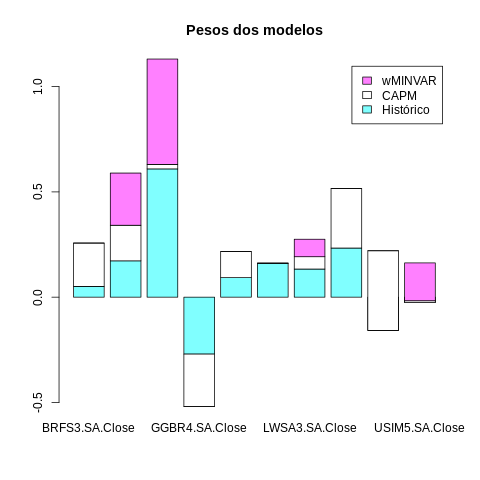

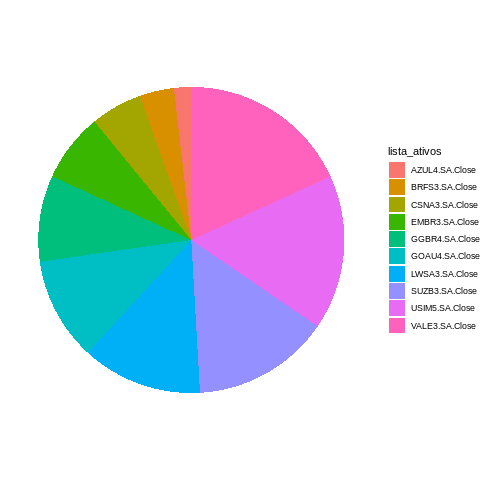

In [12]:
%%R

colnames(wCAPM)<-c("CAPM")
colnames(wHIST)<-c("Histórico")
pesos= cbind(wHIST, wCAPM, wMINVAR)
barplot(t(pesos), main="Pesos dos modelos", names.ar= lista_ativos,  col=cm.colors(ncol(pesos)), legend=colnames(pesos))
#pie(wCAPM,col=cm.colors(ncol(wCAPM)+2), labels = names(wCAPM) )
ggplot(data.frame(wCAPM), aes(x="", y=lista_ativos, fill=lista_ativos)) +
  geom_bar(stat="identity", width=1) +
  coord_polar("y", start=0)+  
  theme_void() # remove background, grid, numeric labels




In [20]:
%%R
dfpesos= data.frame(pesos) %>% mutate(across(is.numeric, ~ round(., 5)))
#as_hux(dfpesos) %>%
     # set_outer_borders(0.4) %>%
      #map_background_color(by_rows("grey95", "white")) %>%
     # add_rownames()  %>%
     # add_colnames()
     # set_background_color("white") %>%
     # map_text_color(by_ranges(c(-0.0, 0.2), c("red", "black", "green3")))
print(dfpesos)

               Histórico     CAPM wMINVAR
BRFS3.SA.Close   0.05105  0.20588 0.00000
AZUL4.SA.Close   0.17264  0.16905 0.24757
CSNA3.SA.Close   0.60898  0.02172 0.50000
GGBR4.SA.Close  -0.27021 -0.24911 0.00000
EMBR3.SA.Close   0.09311  0.12363 0.00000
SUZB3.SA.Close   0.16088  0.00102 0.00000
LWSA3.SA.Close   0.13364  0.05864 0.08287
VALE3.SA.Close   0.23338  0.28215 0.00000
GOAU4.SA.Close  -0.15804  0.37845 0.00000
USIM5.SA.Close  -0.02541  0.00857 0.17956
[1] "USIM5.SA.Close"


In [24]:
for i in range(len(lista_ativos)): lista_ativos[i]= lista_ativos[i].replace('.Close','') #limpa os nomes dos ativos

In [25]:
Yexp= confianca(lista_ativos)   ## Demoraaaaaaaaado - pega lista de valores usados para medir a confianca em cada view

In [ ]:
val=[] # vetor de valores intrinsicos da acao-    demoraaaaaado  pra kct 
for ativo in lista_ativos:
    time.sleep(2)
    temp= calculate_intrinsic_value(ativo)
    val.append(temp)

In [27]:
def inver(zz): 
  return np.linalg.inv(zz)

pi= np.pi
e= np.exp(1)
alfa= []
for x in Yexp: 
  P= 1/(1+ e**((-1)*pi*x))  ## probabilidade dada por regressao logistica
  a=(1-P)/P ##transformacao deduzida de Idradek
  alfa.append(a)
alf=np.asarray(alfa)
diagS=np.diagonal(S) 
tau= 0.0000358
Omega= np.diag(alf*diagS) # calculo aqui a matriz diagonal que multiplica as variancias 
##essa matriz omega vai ser o fator de confianca que temos em nossas análises do mercado


valor= np.asarray(val) # esse eh o vetor de precos intrinsicos dos ativos
margem= valor- preco_hj 
ret_fund=margem/preco_hj #retornos esperados no LP(segundo fundamentos)
##############################################
Q= ret_fund  # não faz diferenca dividir/ multiplicar por valor, pois oq importa sao as proporcoes
PI= np.asarray(miCAPM)
OM_1=np.linalg.inv(Omega)
termo1= inver(inver(tau*S) + OM_1)
termo2= np.matmul(inver(tau*S), PI.T) + np.matmul(OM_1, Q.T)
miBL= np.matmul(termo1,termo2)
zBL= inver(S).dot((miBL-rf.T))
wBL= zBL/(sum(zBL))
wBL

array([[ 0.20219045],
       [ 0.15665861],
       [ 0.02208535],
       [-0.24302547],
       [ 0.20356565],
       [-0.00415989],
       [ 0.05094658],
       [ 0.15196988],
       [ 0.43115185],
       [ 0.02861699]])

In [36]:
%%R --i wBL --o wHIST --o wCAPM
wCAPM
wHIST

print(sum(wCAPM**2- wBL**2))
print(sum(wHIST**2- wBL**2))
print(sum(wHIST**2- wCAPM**2))
cbind(pesos,wBL)

[1] -0.1065559
[1] 0.1271017
[1] 0.2336576
           Histórico         CAPM       wMINVAR            
BRFS3.SA  0.05104577  0.205879417  4.871741e-18  0.19677318
AZUL4.SA  0.17263543  0.169052832  2.475714e-01  0.13844533
CSNA3.SA  0.60897642  0.021720414  5.000000e-01  0.02261868
GGBR4.SA -0.27020974 -0.249105720 -6.196732e-16 -0.23412373
EMBR3.SA  0.09311010  0.123634220 -2.588512e-31  0.32106520
SUZB3.SA  0.16088135  0.001016350  2.155862e-18 -0.01177087
LWSA3.SA  0.13363956  0.058640205  8.286518e-02  0.03963533
VALE3.SA  0.23337637  0.282147234 -1.218345e-17 -0.03939372
GOAU4.SA -0.15804479  0.378445022  0.000000e+00  0.50866743
USIM5.SA -0.02541047  0.008570027  1.795635e-01  0.05808317


In [33]:
tau= 0.0001
wvec=[]
wdif=[]
for t in range(900):
  tau= 0.00001+ t/10000000
  Omega= np.diag(alf*diagS) # calculo aqui a matriz diagonal que multiplica as variancias 
  ##essa matriz omega vai ser o fator de confianca que temos em nossas análises do mercado


  valor= np.asarray(val) # esse eh o vetor de precos intrinsicos dos ativos
  margem= valor- preco_hj 
  ret_fund=margem/preco_hj #retornos esperados no LP(segundo fundamentos)
  ##############################################
  Q= ret_fund  # divido por 252? 
  PI= np.asarray(miCAPM)
  OM_1=np.linalg.inv(Omega)
  termo1= inver(inver(tau*S) + OM_1)
  termo2= np.matmul(inver(tau*S), PI.T) + np.matmul(OM_1, Q.T)
  miBL= np.matmul(termo1,termo2)
  zBL= inver(S).dot((miBL-rf.T))
  wBL= zBL/(sum(zBL))
  wvec.append(wBL)
  wdif.append(sum(wBL**2- wCAPM**2))

In [35]:
min_value = min(np.absolute(wdif))
min_index = wdif.index((-1)*min_value)
min_index/10000000+ 0.00001


3.0500000000000003e-05

In [ ]:
zQ= inver(S).dot((Q-rf).T)
wQ= zQ/(sum(zQ))
wQ

In [23]:
%%R
length(portfolioPrices)

[1] 2140
